#NLP PROJECT SEQ 2 SE1 WITH ATTENTION MACHINE TRANSLATION 
Masroor Ahmed 19I-0498
Aftab Ali 19I-0466

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

Reading

In [5]:
df = pd.read_csv('EnglishUrdu.csv',encoding='utf8')
df.head()

,English Sentence,Urdu_Sentence
0,Los Angeles has lost night straight and 13 of ...,لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات ...
1,Opposite qualities of meaning of person's name,آنکھ کا اندھا نام نین سکھ
2,To show anger after getting embarrassed,کھسیانی بلی کھمبا نوچے
3,Money earned the wrong way will be taken away,چوری کا مال موری میں
4,To talk big without having a big position,چھوٹا منہ بڑی بات


In [6]:
df = df.iloc[:700,:]
df.head()

,English Sentence,Urdu_Sentence
0,Los Angeles has lost night straight and 13 of ...,لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات ...
1,Opposite qualities of meaning of person's name,آنکھ کا اندھا نام نین سکھ
2,To show anger after getting embarrassed,کھسیانی بلی کھمبا نوچے
3,Money earned the wrong way will be taken away,چوری کا مال موری میں
4,To talk big without having a big position,چھوٹا منہ بڑی بات


PreProcessing

In [7]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

def cleanerUrdu(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

In [9]:
df.iloc[:,0] = df['English Sentence'].apply(func=cleanerEng)
df.iloc[:,1] = df['Urdu_Sentence'].apply(func= cleanerUrdu)
df.iloc[:,0] = df['English Sentence'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['Urdu_Sentence'].apply(func= lambda x : (str(x).split()))

In [10]:
def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)

In [12]:
df.iloc[:,0] = df['English Sentence'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['Urdu_Sentence'].apply(func= addTokens,start=True)

In [13]:
df.iloc[79,1]

['<START>', 'زندگی', 'پھولوں', 'کی', 'سیج', 'نہیں', '<END>']

Importing Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [15]:
data = df.values

In [16]:
data[:,1].shape

(699,)

Attatching marks at Start and end of the sentence  train and test

In [17]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

    

In [18]:
English_vocab = vocab(data[:,0],token=False)
Urdu_vocab = vocab(data[:,1],token=True)

In [19]:
for idx in Urdu_vocab.x[2]:
  print(Urdu_vocab.idx2word[int(idx)],end=' ')

<START> کھسیانی بلی کھمبا نوچے <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [20]:
class parallelData(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Urdu_vocab.x

  def __getitem__(self,i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return len(self.x)


In [21]:
dataset = parallelData()

In [22]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [23]:
Urdu_vocab.x[90].shape

torch.Size([35])

In [24]:
torch.cuda.device_count()

0

Encoder,Decoder implementation with SEQ2SEQ AND ATTENTION MODEL TOO

In [25]:
#Model preparation

class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    #in order to convert bidirectional hidden state to unidirectional if LSTM is bidirectional 
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    # print(output.shape, x.shape)
    #output shape = [batch_size, seq_len, 2*hidden_size] 
    #hidden shape =[1(layers), batch_size, hidden_size]
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of Urdu vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among Urdu vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    to have control over output we have to take sentence as word by word
    therefore seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, Urdu_vocab_size]
    
    #just for removing extra dim
    output = output.squeeze(dim=1) #shape [batch, Urdu_vocab_size]

    return output, hidden_state, cell_state


##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among Urdu vocab therefore out_feature=input_size

    #encoder_states from encoder => [batch, seq_len(35), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(35), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2
    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(35), hidden_size*3]  out = [batch, seq_len(35), 1]
    att_weights = self.softmax(energy)
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    

    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]

    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]

    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, Urdu_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, Urdu_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of Urdu sentences[batch, sentece(padded)]
    target = batch of English sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    Urdu_vocab_size = Urdu_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, Urdu_vocab_size)).to(device)

    _, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of Urdu sentences[batch, sentece(padded)]
    target = batch of English sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    Urdu_vocab_size = Urdu_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, Urdu_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]



In [26]:
##training
epochs = 120
learning_rate = 0.0006
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True


In [27]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
it = iter(loader)
x,y = next(it)
print(x.shape,y.shape)
len(dataset)


torch.Size([100, 28]) torch.Size([100, 35])


699

In [29]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
# DE = decoder(Urdu_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = AttnDecoder(Urdu_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
# model = seq2seq(ENC,DE).to(device)
model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [30]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())

  

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[1/120] loss=>6.478342533111572


  0%|          | 0/7 [00:00<?, ?it/s]

[2/120] loss=>5.9790520668029785


  0%|          | 0/7 [00:00<?, ?it/s]

[3/120] loss=>5.622457027435303


  0%|          | 0/7 [00:00<?, ?it/s]

[4/120] loss=>5.621542453765869


  0%|          | 0/7 [00:00<?, ?it/s]

[5/120] loss=>5.4727606773376465


  0%|          | 0/7 [00:00<?, ?it/s]

[6/120] loss=>5.397167682647705


  0%|          | 0/7 [00:00<?, ?it/s]

[7/120] loss=>5.142129898071289


  0%|          | 0/7 [00:00<?, ?it/s]

[8/120] loss=>5.157357215881348


  0%|          | 0/7 [00:00<?, ?it/s]

[9/120] loss=>5.2274699211120605


  0%|          | 0/7 [00:00<?, ?it/s]

[10/120] loss=>5.261986255645752


  0%|          | 0/7 [00:00<?, ?it/s]

[11/120] loss=>4.9949049949646


  0%|          | 0/7 [00:00<?, ?it/s]

[12/120] loss=>4.869208335876465


  0%|          | 0/7 [00:00<?, ?it/s]

[13/120] loss=>4.934769630432129


  0%|          | 0/7 [00:00<?, ?it/s]

[14/120] loss=>4.622713088989258


  0%|          | 0/7 [00:00<?, ?it/s]

[15/120] loss=>4.582411289215088


  0%|          | 0/7 [00:00<?, ?it/s]

[16/120] loss=>4.432040214538574


  0%|          | 0/7 [00:00<?, ?it/s]

[17/120] loss=>4.456222057342529


  0%|          | 0/7 [00:00<?, ?it/s]

[18/120] loss=>4.109851837158203


  0%|          | 0/7 [00:00<?, ?it/s]

[19/120] loss=>4.070827484130859


  0%|          | 0/7 [00:00<?, ?it/s]

[20/120] loss=>4.019852638244629


  0%|          | 0/7 [00:00<?, ?it/s]

[21/120] loss=>3.9293174743652344


  0%|          | 0/7 [00:00<?, ?it/s]

[22/120] loss=>3.6084485054016113


  0%|          | 0/7 [00:00<?, ?it/s]

[23/120] loss=>3.6758792400360107


  0%|          | 0/7 [00:00<?, ?it/s]

[24/120] loss=>3.4830827713012695


  0%|          | 0/7 [00:00<?, ?it/s]

[25/120] loss=>3.377119779586792


  0%|          | 0/7 [00:00<?, ?it/s]

[26/120] loss=>3.248650074005127


  0%|          | 0/7 [00:00<?, ?it/s]

[27/120] loss=>3.337636709213257


  0%|          | 0/7 [00:00<?, ?it/s]

[28/120] loss=>3.254033327102661


  0%|          | 0/7 [00:00<?, ?it/s]

[29/120] loss=>2.975694417953491


  0%|          | 0/7 [00:00<?, ?it/s]

[30/120] loss=>2.945089101791382


  0%|          | 0/7 [00:00<?, ?it/s]

[31/120] loss=>2.815610408782959


  0%|          | 0/7 [00:00<?, ?it/s]

[32/120] loss=>2.610100507736206


  0%|          | 0/7 [00:00<?, ?it/s]

[33/120] loss=>2.5405678749084473


  0%|          | 0/7 [00:00<?, ?it/s]

[34/120] loss=>2.328291177749634


  0%|          | 0/7 [00:00<?, ?it/s]

[35/120] loss=>2.37422251701355


  0%|          | 0/7 [00:00<?, ?it/s]

[36/120] loss=>2.1767210960388184


  0%|          | 0/7 [00:00<?, ?it/s]

[37/120] loss=>2.0642428398132324


  0%|          | 0/7 [00:00<?, ?it/s]

[38/120] loss=>1.9575203657150269


  0%|          | 0/7 [00:00<?, ?it/s]

[39/120] loss=>1.902168869972229


  0%|          | 0/7 [00:00<?, ?it/s]

[40/120] loss=>1.8863943815231323


  0%|          | 0/7 [00:00<?, ?it/s]

[41/120] loss=>1.7686455249786377


  0%|          | 0/7 [00:00<?, ?it/s]

[42/120] loss=>1.7692596912384033


  0%|          | 0/7 [00:00<?, ?it/s]

[43/120] loss=>1.5814461708068848


  0%|          | 0/7 [00:00<?, ?it/s]

[44/120] loss=>1.4826531410217285


  0%|          | 0/7 [00:00<?, ?it/s]

[45/120] loss=>1.3736847639083862


  0%|          | 0/7 [00:00<?, ?it/s]

[46/120] loss=>1.2944855690002441


  0%|          | 0/7 [00:00<?, ?it/s]

[47/120] loss=>1.3364651203155518


  0%|          | 0/7 [00:00<?, ?it/s]

[48/120] loss=>1.2319811582565308


  0%|          | 0/7 [00:00<?, ?it/s]

[49/120] loss=>1.1988778114318848


  0%|          | 0/7 [00:00<?, ?it/s]

[50/120] loss=>1.104486107826233


  0%|          | 0/7 [00:00<?, ?it/s]

[51/120] loss=>0.9998241662979126


  0%|          | 0/7 [00:00<?, ?it/s]

[52/120] loss=>0.994540810585022


  0%|          | 0/7 [00:00<?, ?it/s]

[53/120] loss=>0.8937318921089172


  0%|          | 0/7 [00:00<?, ?it/s]

[54/120] loss=>0.8663419485092163


  0%|          | 0/7 [00:00<?, ?it/s]

[55/120] loss=>0.79056316614151


  0%|          | 0/7 [00:00<?, ?it/s]

[56/120] loss=>0.8315151333808899


  0%|          | 0/7 [00:00<?, ?it/s]

[57/120] loss=>0.7309175133705139


  0%|          | 0/7 [00:00<?, ?it/s]

[58/120] loss=>0.7568933367729187


  0%|          | 0/7 [00:00<?, ?it/s]

[59/120] loss=>0.7040877938270569


  0%|          | 0/7 [00:00<?, ?it/s]

[60/120] loss=>0.6235251426696777


  0%|          | 0/7 [00:00<?, ?it/s]

[61/120] loss=>0.5520563721656799


  0%|          | 0/7 [00:00<?, ?it/s]

[62/120] loss=>0.5574899911880493


  0%|          | 0/7 [00:00<?, ?it/s]

[63/120] loss=>0.5613905191421509


  0%|          | 0/7 [00:00<?, ?it/s]

[64/120] loss=>0.5006944537162781


  0%|          | 0/7 [00:00<?, ?it/s]

[65/120] loss=>0.46750548481941223


  0%|          | 0/7 [00:00<?, ?it/s]

[66/120] loss=>0.46085894107818604


  0%|          | 0/7 [00:00<?, ?it/s]

[67/120] loss=>0.4108395576477051


  0%|          | 0/7 [00:00<?, ?it/s]

[68/120] loss=>0.40734413266181946


  0%|          | 0/7 [00:00<?, ?it/s]

[69/120] loss=>0.3729080855846405


  0%|          | 0/7 [00:00<?, ?it/s]

[70/120] loss=>0.3601091206073761


  0%|          | 0/7 [00:00<?, ?it/s]

[71/120] loss=>0.3514641523361206


  0%|          | 0/7 [00:00<?, ?it/s]

[72/120] loss=>0.3245522379875183


  0%|          | 0/7 [00:00<?, ?it/s]

[73/120] loss=>0.32203978300094604


  0%|          | 0/7 [00:00<?, ?it/s]

[74/120] loss=>0.2982461154460907


  0%|          | 0/7 [00:00<?, ?it/s]

[75/120] loss=>0.2789739966392517


  0%|          | 0/7 [00:00<?, ?it/s]

[76/120] loss=>0.27804651856422424


  0%|          | 0/7 [00:00<?, ?it/s]

[77/120] loss=>0.2545011043548584


  0%|          | 0/7 [00:00<?, ?it/s]

[78/120] loss=>0.257063090801239


  0%|          | 0/7 [00:00<?, ?it/s]

[79/120] loss=>0.252393513917923


  0%|          | 0/7 [00:00<?, ?it/s]

[80/120] loss=>0.2232757806777954


  0%|          | 0/7 [00:00<?, ?it/s]

[81/120] loss=>0.21478180587291718


  0%|          | 0/7 [00:00<?, ?it/s]

[82/120] loss=>0.22024258971214294


  0%|          | 0/7 [00:00<?, ?it/s]

[83/120] loss=>0.21087276935577393


  0%|          | 0/7 [00:00<?, ?it/s]

[84/120] loss=>0.1961546689271927


  0%|          | 0/7 [00:00<?, ?it/s]

[85/120] loss=>0.203328475356102


  0%|          | 0/7 [00:00<?, ?it/s]

[86/120] loss=>0.17588040232658386


  0%|          | 0/7 [00:00<?, ?it/s]

[87/120] loss=>0.18388082087039948


  0%|          | 0/7 [00:00<?, ?it/s]

[88/120] loss=>0.16352978348731995


  0%|          | 0/7 [00:00<?, ?it/s]

[89/120] loss=>0.1694093644618988


  0%|          | 0/7 [00:00<?, ?it/s]

[90/120] loss=>0.16196727752685547


  0%|          | 0/7 [00:00<?, ?it/s]

[91/120] loss=>0.14693975448608398


  0%|          | 0/7 [00:00<?, ?it/s]

[92/120] loss=>0.14425025880336761


  0%|          | 0/7 [00:00<?, ?it/s]

[93/120] loss=>0.146576389670372


  0%|          | 0/7 [00:00<?, ?it/s]

[94/120] loss=>0.14864753186702728


  0%|          | 0/7 [00:00<?, ?it/s]

[95/120] loss=>0.15151630342006683


  0%|          | 0/7 [00:00<?, ?it/s]

[96/120] loss=>0.13430331647396088


  0%|          | 0/7 [00:00<?, ?it/s]

[97/120] loss=>0.12589159607887268


  0%|          | 0/7 [00:00<?, ?it/s]

[98/120] loss=>0.1308290958404541


  0%|          | 0/7 [00:00<?, ?it/s]

[99/120] loss=>0.11313125491142273


  0%|          | 0/7 [00:00<?, ?it/s]

[100/120] loss=>0.11796001344919205


  0%|          | 0/7 [00:00<?, ?it/s]

[101/120] loss=>0.1070544421672821


  0%|          | 0/7 [00:00<?, ?it/s]

[102/120] loss=>0.10740212351083755


  0%|          | 0/7 [00:00<?, ?it/s]

[103/120] loss=>0.1061544418334961


  0%|          | 0/7 [00:00<?, ?it/s]

[104/120] loss=>0.10537465661764145


  0%|          | 0/7 [00:00<?, ?it/s]

[105/120] loss=>0.10266713798046112


  0%|          | 0/7 [00:00<?, ?it/s]

[106/120] loss=>0.10023589432239532


  0%|          | 0/7 [00:00<?, ?it/s]

[107/120] loss=>0.10155165195465088


  0%|          | 0/7 [00:00<?, ?it/s]

[108/120] loss=>0.10192710161209106


  0%|          | 0/7 [00:00<?, ?it/s]

[109/120] loss=>0.10347926616668701


  0%|          | 0/7 [00:00<?, ?it/s]

[110/120] loss=>0.0951898917555809


  0%|          | 0/7 [00:00<?, ?it/s]

[111/120] loss=>0.09055160731077194


  0%|          | 0/7 [00:00<?, ?it/s]

[112/120] loss=>0.08734214305877686


  0%|          | 0/7 [00:00<?, ?it/s]

[113/120] loss=>0.08839451521635056


  0%|          | 0/7 [00:00<?, ?it/s]

[114/120] loss=>0.08489341288805008


  0%|          | 0/7 [00:00<?, ?it/s]

[115/120] loss=>0.08499874174594879


  0%|          | 0/7 [00:00<?, ?it/s]

[116/120] loss=>0.07901806384325027


  0%|          | 0/7 [00:00<?, ?it/s]

[117/120] loss=>0.07754454761743546


  0%|          | 0/7 [00:00<?, ?it/s]

[118/120] loss=>0.07551882416009903


  0%|          | 0/7 [00:00<?, ?it/s]

[119/120] loss=>0.08304718881845474


  0%|          | 0/7 [00:00<?, ?it/s]

[120/120] loss=>0.07810163497924805


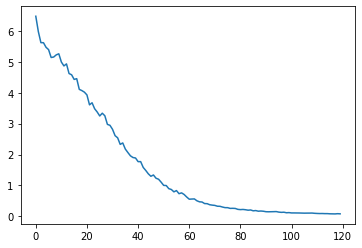

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

In [32]:
torch.save(model.state_dict(),'model.pt')
# from google.colab import files
# files.download('model.pt')

In [33]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()

    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Urdu_vocab.idx2word[id])
    
    return res


In [34]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [35]:
prediction(dataset[50][0])

two hunts with one arrow <END> 


['ایک', 'تیر', 'سے', 'دو', 'شکار', '<END>']

In [36]:
prediction(dataset[100][0])

health is wealth <END> 


['تندرستی', 'ہزار', 'نعمت', 'ہے', '<END>']

In [37]:
prediction(dataset[71][0])

i don t measure a man s success by how high he climbs but how high he bounces when he hits bottom <END> 


['میں',
 'کسی',
 'انسان',
 'کی',
 'کامیابی',
 'کو',
 'اس',
 'طرح',
 'نہیں',
 'جانچتا',
 'کہ',
 'وہ',
 'کتنے',
 'بلند',
 'مقام',
 'تک',
 'پہنچا',
 'لیکن',
 'بجز',
 'اس',
 'کے',
 'کہ',
 'وہ',
 'پستی',
 'میں',
 'گر',
 'کر',
 'واپس',
 'کتنی',
 'بلندی',
 'پر',
 'پہنچا',
 '<END>']

In [39]:
prediction(dataset[random.randint(0,700)][0])

all ears <END> 


['توجہ', 'سے', 'سننا', '<END>']

In [41]:
for i in range(15):
  prediction(dataset[random.randint(0,700)][0])

necessity is the mother of invention <END> 
no man can serve two masters <END> 
to lend light to the sun <END> 
uneasy lies the head that wears a crown <END> 
an appropriate action at the right time and right place is appreciated <END> 
snake in grass <END> 
rest in peace <END> 
atone for your sins <END> 
add fuel to fire <END> 
an open door will tempt a saint <END> 
as sharp as a needle <END> 
as shy as a school girl <END> 
love is blind <END> 
sell like hot cake <END> 
every cock fights best its own dunghill <END> 


In [42]:
dataset[3][0]

tensor([30., 31., 17., 32., 33., 34., 35., 36., 37.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [43]:
def get(sent):
  # sentence = sentence.lower()
  # sent = sentence.split()
  # sent.append('<END>')
  # print(sent)

  toks = []
  for word in sent:
    if English_vocab.word2idx.get(word) is None:
      toks.append(English_vocab.word2idx['the'])
    else:
      toks.append(English_vocab.word2idx[word])
  # print(toks)
  sent = torch.tensor(toks).float()
  res = prediction(sent)
  # print(res)
  return res

In [ ]:
#bleu score calculation

In [45]:
tdf = pd.read_csv('EnglishUrdu.csv')
# tdf.drop(columns=['source'],inplace=True)
tdf = tdf.iloc[500:600,:]
tdf.head()

,English Sentence,Urdu_Sentence
500,Dry bread at the home is better than the roast...,گھر کی آدھی باہر کی ساری
501,Eat oneâ€™s words,الفاظ واپس لینا
502,East or west home is the best,جو سکھ چوپارے نہ بلخ نہ بخارے
503,Easy come easy go,مال مفت دل بےرحم
504,Embark first debark last,ناوَ میں چڑھے سب سے پہلے،اترے سب سے بعد


In [46]:
tdf.iloc[:,0] = tdf['English Sentence'].apply(func=cleanerEng)
tdf.iloc[:,1] = tdf['Urdu_Sentence'].apply(func= cleanerUrdu)
tdf.iloc[:,0] = tdf['English Sentence'].apply(func= lambda x : (str(x).split()))
tdf.iloc[:,1] = tdf['Urdu_Sentence'].apply(func= lambda x : (str(x).split()))

In [47]:
tdf.head()

,English Sentence,Urdu_Sentence
500,"[dry, bread, at, the, home, is, better, than, ...","[گھر, کی, آدھی, باہر, کی, ساری]"
501,"[eat, one, s, words]","[الفاظ, واپس, لینا]"
502,"[east, or, west, home, is, the, best]","[جو, سکھ, چوپارے, نہ, بلخ, نہ, بخارے]"
503,"[easy, come, easy, go]","[مال, مفت, دل, بےرحم]"
504,"[embark, first, debark, last]","[ناوَ, میں, چڑھے, سب, سے, پہلے،اترے, سب, سے, بعد]"


In [48]:
tdf.iloc[:,0] = tdf['English Sentence'].apply(func= addTokens,start=False)

In [49]:
tdf.head()

,English Sentence,Urdu_Sentence
500,"[dry, bread, at, the, home, is, better, than, ...","[گھر, کی, آدھی, باہر, کی, ساری]"
501,"[eat, one, s, words, <END>]","[الفاظ, واپس, لینا]"
502,"[east, or, west, home, is, the, best, <END>]","[جو, سکھ, چوپارے, نہ, بلخ, نہ, بخارے]"
503,"[easy, come, easy, go, <END>]","[مال, مفت, دل, بےرحم]"
504,"[embark, first, debark, last, <END>]","[ناوَ, میں, چڑھے, سب, سے, پہلے،اترے, سب, سے, بعد]"


In [50]:
tdata = tdf.values
test_dataset = vocab(tdata[:,0],token=False)

In [85]:

print(tdata.shape[0])
list_refrences = []
list_hypothesis = []
for i in tqdm(range(int(tdata.shape[0]/4))):
  list_refrences.append(tdata[i,0][:-1])
  list_hypothesis.append((get(tdata[i,0])[:-1]))

100


  0%|          | 0/25 [00:00<?, ?it/s]

dry bread at the home is better than the roasted meat abroad <END> 
eat one s words <END> 
east or west home is the best <END> 
easy come easy go <END> 
embark first debark last <END> 
empty vessels make much noise <END> 
even walls have ears <END> 
every cock fights best its own dunghill <END> 
every day has its night <END> 
every man knows his business best <END> 
everything is permitted in love and war <END> 
everything looks beautiful in its own season <END> 
every tide has its ebb <END> 
every tub must stand upon its own bottom <END> 
evidence does not need proof <END> 
example is better than precept <END> 
expect no good in return <END> 
feather one s nest <END> 
face the music <END> 
far cry from <END> 
first come first serve <END> 
first sow first mow <END> 
for a born fool <END> 
forbidden fruits are sweet <END> 
forgiveness is the noblest revenge <END> 


Bleu Score

In [81]:
import nltk 
print(f"bleu-1 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(1.0,0.0,0.0,0.0))}")
print(f"bleu-2 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.5,0.5,0.0))}")
print(f"bleu-3 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.33,0.33,0.33,0.0))}")
print(f"bleu-4 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.25,0.25,0.25,0.25))}")

bleu-1 : 0
bleu-2 : 0
bleu-3 : 0
bleu-4 : 0


TypeError: unhashable type: 'list'